In [1]:
from utils import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from scipy import signal
plt.style.use("light")

In [2]:
class GuidewireExperiment:
    def __init__(self, positions):
        self.positions = positions
        self.timesteps = len(self.positions)
        self.n_spheres = len(self.positions["0"]["sphere"])
        self.sphere_pos = self.get_all_spheres()
        self.total_time = self.get_total_time()
        self.elapsed_time = self.get_elapsed_time()
        self.delta = self.get_delta()
        
    def get_all_spheres(self):
        return np.array([self.get_sphere_position(idx) for idx in range(self.n_spheres)])

    def get_sphere_position(self, idx):
        sphere_pos = np.array([np.array([
            self.positions[str(i)]["sphere"][str(idx)]["x"], 
            self.positions[str(i)]["sphere"][str(idx)]["y"], 
            self.positions[str(i)]["sphere"][str(idx)]["z"]]) for i in range(0, self.timesteps)])
        return sphere_pos# - sphere_pos[0]

    def get_total_time(self):
        total_time = [self.positions[str(i)]["totalTime"] for i in range(0, self.timesteps)]
        return total_time
    
    def get_elapsed_time(self):
        elapsed_time = [self.positions["0"]["elapsedMilliseconds"]]
        for i in range(1,self.timesteps):
            elapsed_time.append(elapsed_time[-1]+self.positions[str(i)]["elapsedMilliseconds"])
        # elapsed_time = [self.positions[str(i)]["elapsedMilliseconds"] for i in range(0, self.timesteps)]
        return np.array(elapsed_time)
    
    def get_delta(self):
        delta = np.array([self.positions[str(i)]["delta"] for i in range(0, self.timesteps)])
        return delta 
    
    def plot_sphere(self, idx, axis=0):
        sphere_pos = self.get_sphere_position(idx)
        
        plt.figure(figsize=(5,5), dpi=70)
        plt.plot(sphere_pos[:,axis])
        plt.xlabel("Timestep")
        plt.ylabel("Position [m]")
        plt.show()
        
    def plot_all_spheres(self, axis=0):
        sphere_matrix = self.sphere_pos[:,:,axis] - self.sphere_pos[:,0,axis,np.newaxis]
        #sphere_matrix -= np.min(sphere_matrix)
        
        plt.figure(figsize=(6,5), dpi=70)
        plt.imshow(sphere_matrix, aspect="auto", cmap="turbo")
        plt.xlabel("Timestep")
        plt.ylabel("Sphere Index")
        plt.colorbar(label="Position [m]")
        plt.show()

    def plot_experiment(self):
        
        time_array = self.get_elapsed_time()/1000
        sphere_pos = self.get_sphere_position(self.n_spheres-1)
        
        fig,ax = plt.subplots(3,1, figsize=(7,7), dpi=70)
        
        ax[0].plot(time_array, self.get_total_time())
        ax[0].set_title("Total Time")
        ax[0].set_ylabel("In-Game Time [s]")
        ax[0].set_xlabel("Real time [s]")
        
        ax[1].plot(time_array, sphere_pos[:,2])
        ax[1].set_title("Last Sphere Displacement")
        ax[1].set_ylabel("Displacement [m]")
        ax[1].set_xlabel("Real time [s]")
        
        ax[2].plot(time_array, self.get_delta())
        ax[2].set_title("Simulation Error")
        ax[2].set_ylabel("Delta [a.u.]")
        ax[2].set_xlabel("Real time [s]")
        
        plt.tight_layout()
        plt.show()


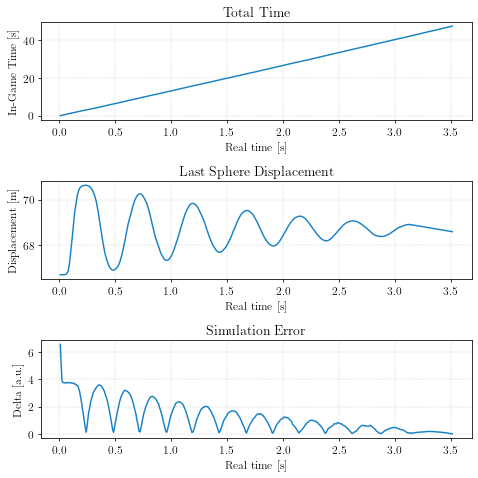

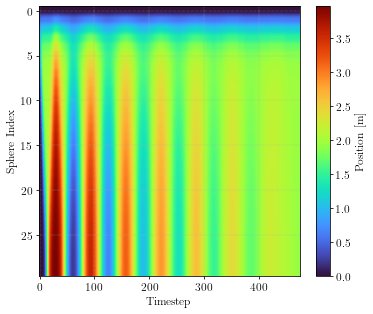

In [27]:
positions = read_json_file("/home/max/Temp/Praktikum/experiments/constraint_solver_steps_1/constraint_solver_steps_1_500/positions.json")

experiment1 = GuidewireExperiment(positions)

experiment1.plot_experiment()
experiment1.plot_all_spheres(axis=2)

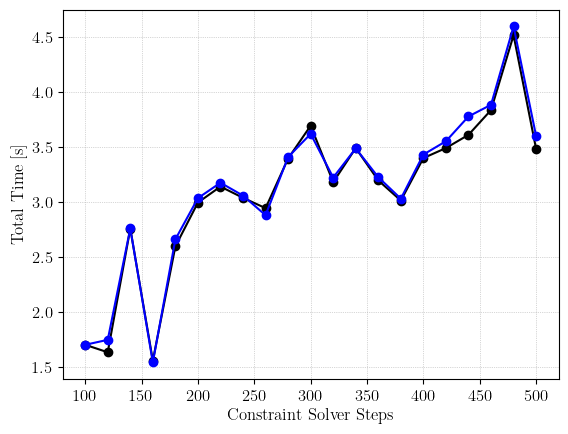

In [28]:
exps = []
time = []
constraint_solver_steps = np.arange(100,520,20)#[100, 200, 300, 400, 500] 
for i in constraint_solver_steps:
    positions = read_json_file(f"/home/max/Temp/Praktikum/experiments/constraint_solver_steps_2/constraint_solver_steps_2_{i}/positions.json")
    exps.append(GuidewireExperiment(positions))
    time.append(exps[-1].get_elapsed_time()[-1]/1000)
    
plt.plot(constraint_solver_steps, time, "o-", color="black")
plt.xlabel("Constraint Solver Steps")
plt.ylabel("Total Time [s]")

exps = []
time = []
for i in constraint_solver_steps:
    positions = read_json_file(f"/home/max/Temp/Praktikum/experiments/constraint_solver_steps_6/constraint_solver_steps_6_{i}/positions.json")
    exps.append(GuidewireExperiment(positions))
    time.append(exps[-1].get_elapsed_time()[-1]/1000)
    
plt.plot(constraint_solver_steps, time, "o-", color="blue")



In [ ]:
fig = plt.figure(figsize=(12,5), dpi=300)
plt.fill_between(np.arange(0, n_new), np.percentile(pred_samples['y_pred_new'], axis=0, q=[10]).ravel()[:],
                 np.percentile(pred_samples['y_pred_new'], axis=0, q=[90]).ravel()[:], alpha = 0.1, color='b', label='90% CI');
plt.fill_between(np.arange(0, n_new), np.percentile(pred_samples['y_pred_new'], axis=0, q=[25]).ravel()[:],
                 np.percentile(pred_samples['y_pred_new'], axis=0, q=[50]).ravel()[:], alpha = 0.25, color='b', label='50% CI');
plt.plot(np.arange(0, n_new), np.mean(pred_samples['y_pred_new'], axis=0)[:], color="blue", label='Mean')
plt.plot(np.arange(T-70),data_germany[70:,0], "o--", color="black", label="Data")
plt.legend()
plt.grid()
plt.vlines(510, 0, 65000, linewidth=3, color="black", alpha=0.5, linestyle="--")
plt.ylabel("Infections")
plt.xlabel("T in Days")
plt.xlim(500,560)
plt.savefig("gp_infections_close.png")

In [33]:
def func(x, a, b):
    return a*np.exp(-x/b)+2#d

def get_decay_rate(experiment, debug=False):
    xs = np.arange(0, experiment.timesteps)

    data = experiment.get_sphere_position(experiment.n_spheres-1)[:,2]
    data = data - data[0]

    # Find the upper peaks of the damped oscillation
    peak_idxs,_ = signal.find_peaks(data)

    peaks_positions = xs[peak_idxs]
    peaks_values = data[peak_idxs]
    
    # Fit exponential decay to the peaks
    popt, pcov = curve_fit(func, peaks_positions, peaks_values, p0=[1, 100])

    if debug:
        plt.title(f"Decay rate: {popt[1]:.5f}")
        plt.plot(xs, data, label="Data")
        plt.scatter(xs[peak_idxs], data[peak_idxs], c="red")
        plt.plot(xs, func(xs, *popt), label="Fitted Curve")
        plt.xlabel("Time steps")
        plt.ylabel("Displacement [a.u.]")
        plt.show()
        
    return popt[1],popt[0]

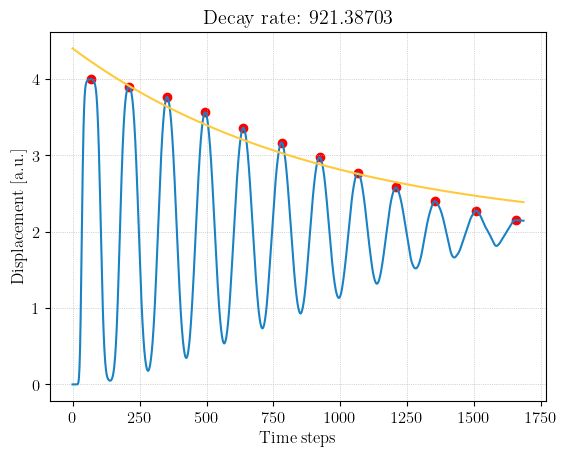

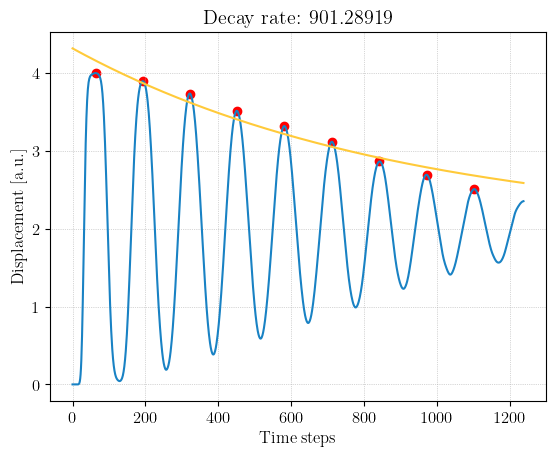

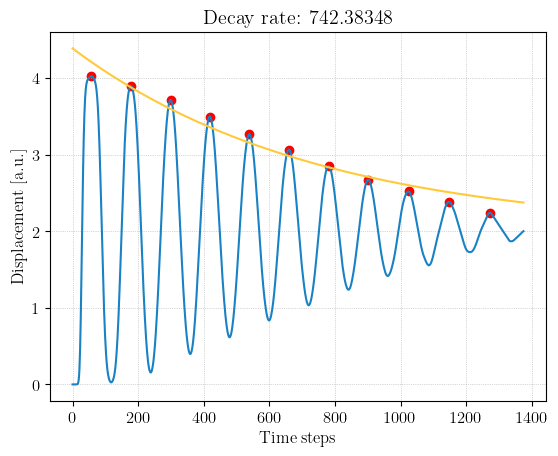

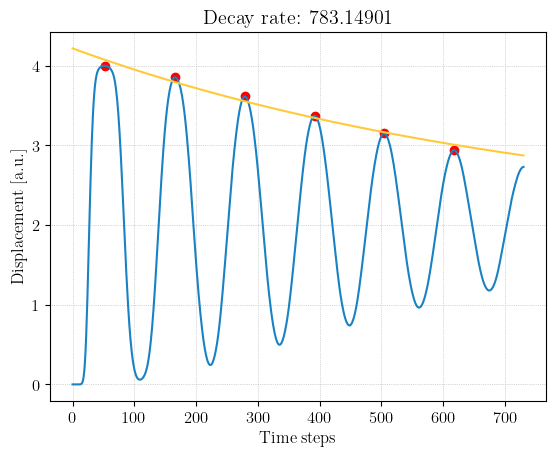

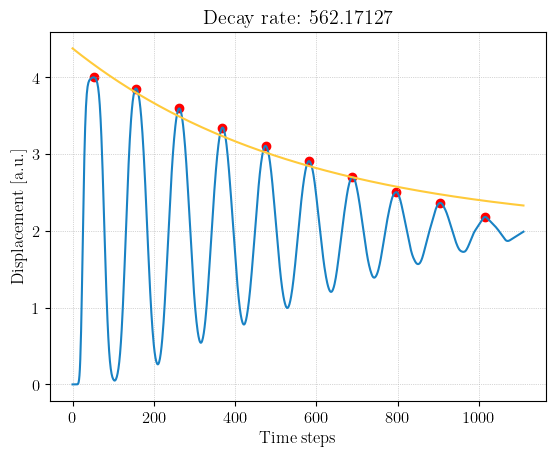

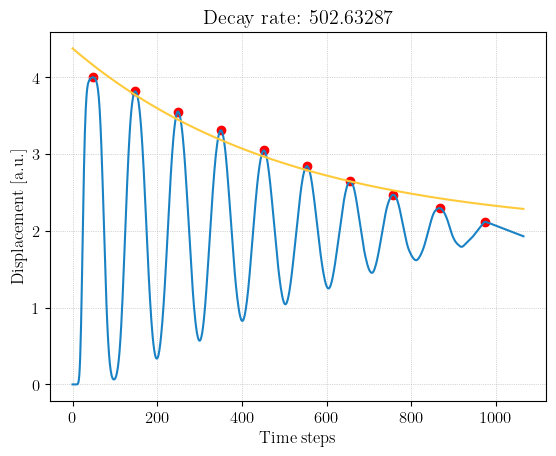

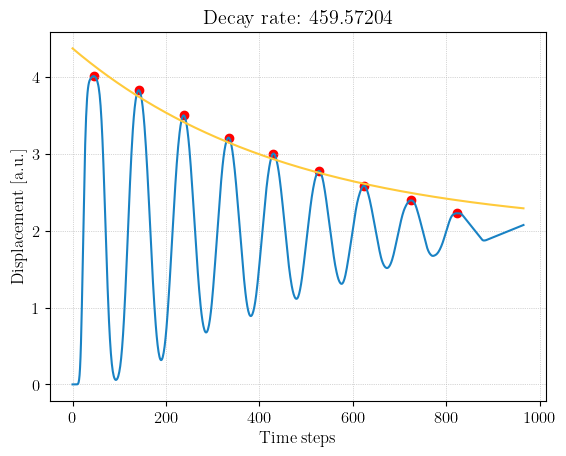

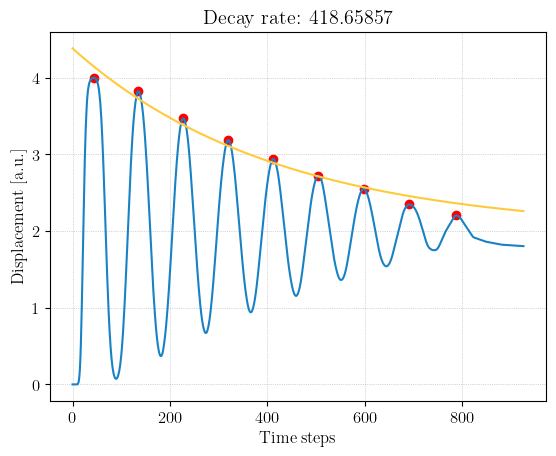

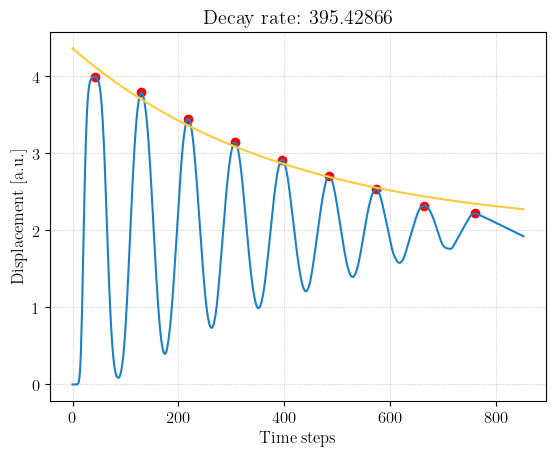

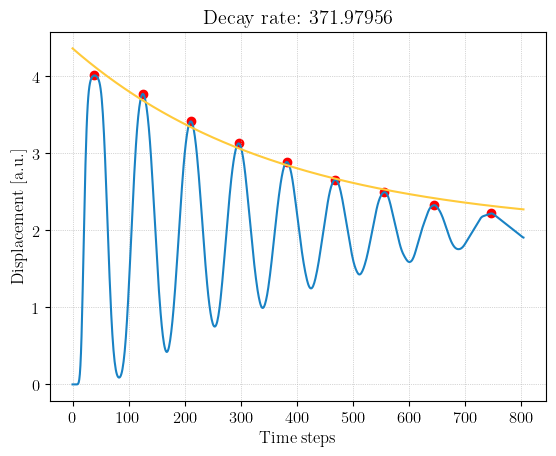

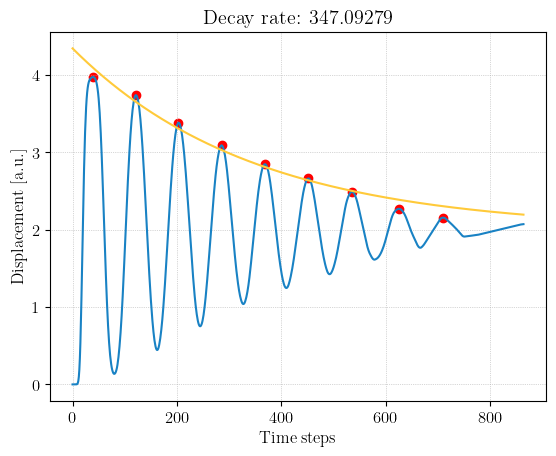

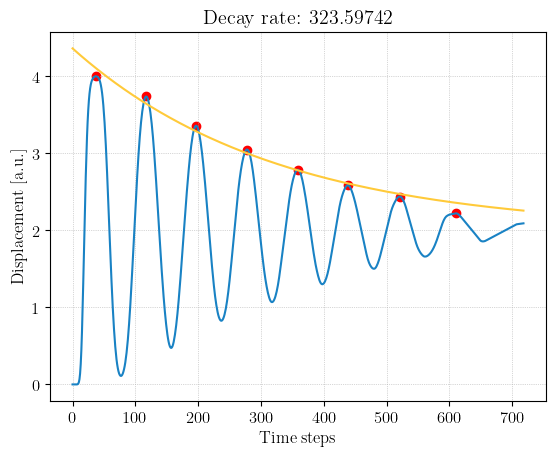

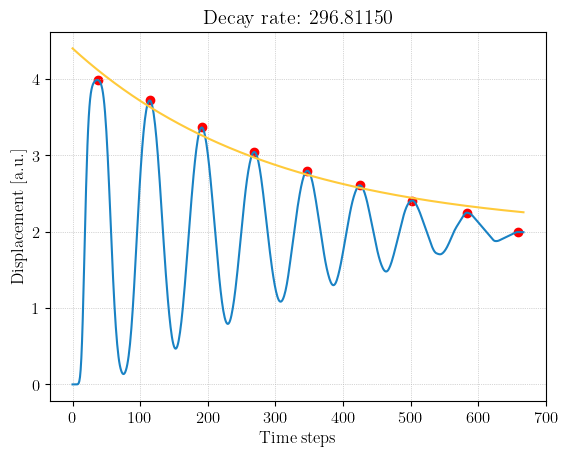

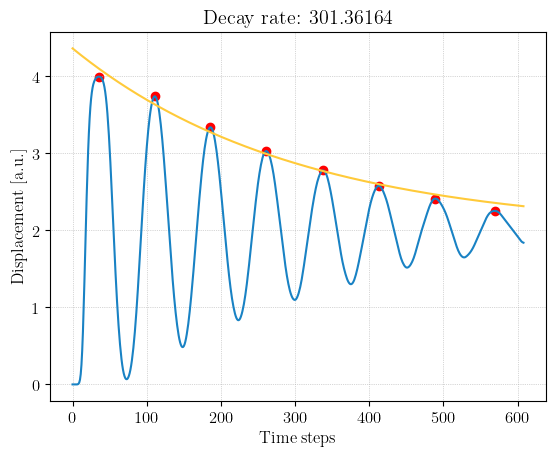

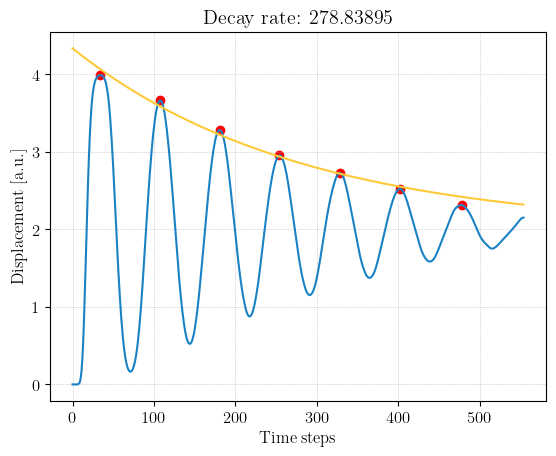

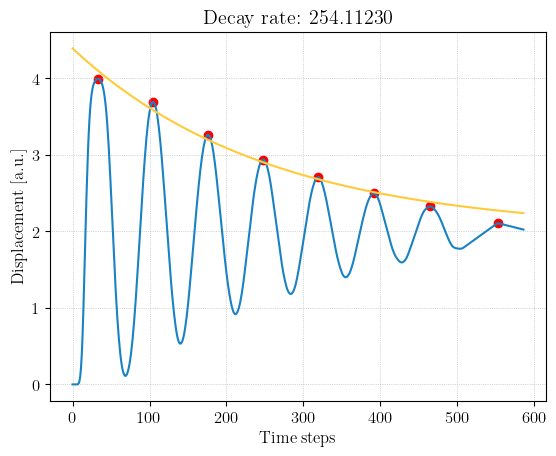

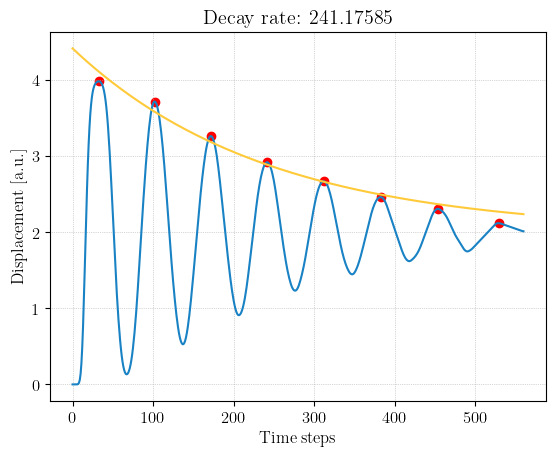

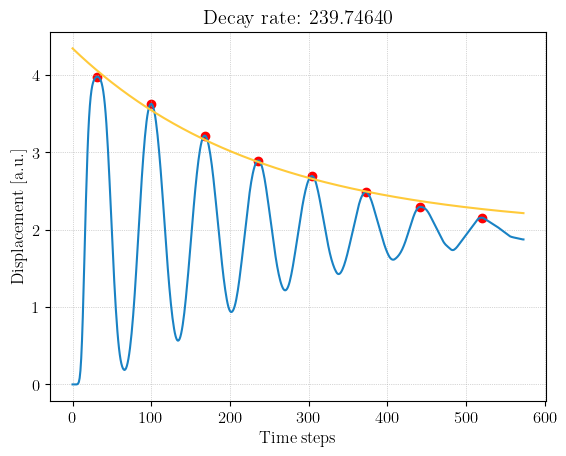

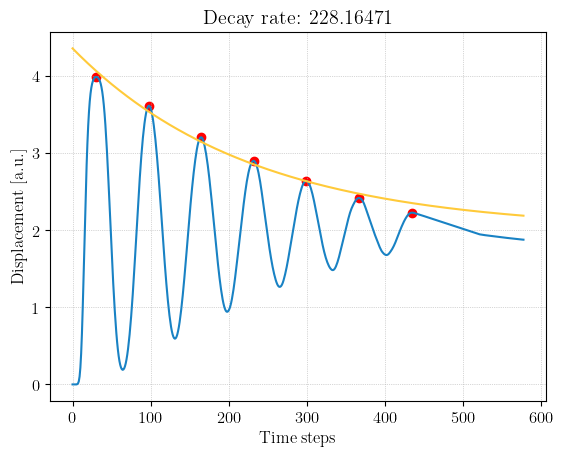

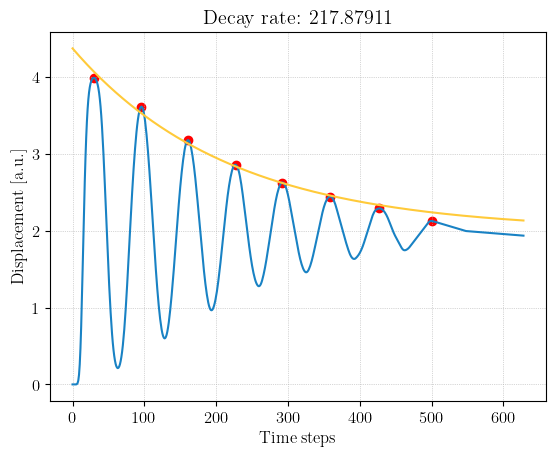

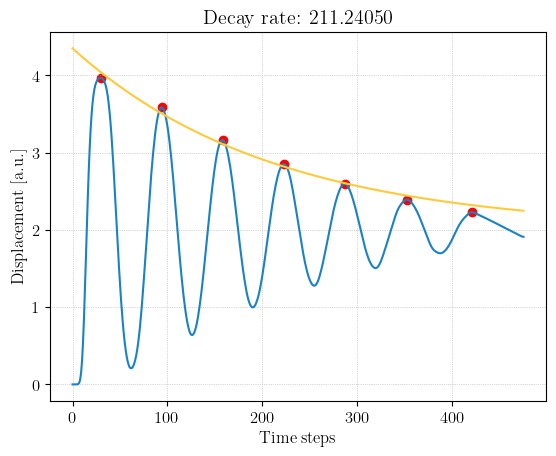

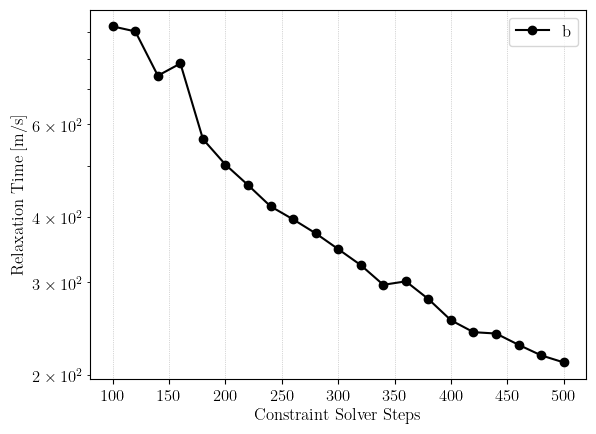

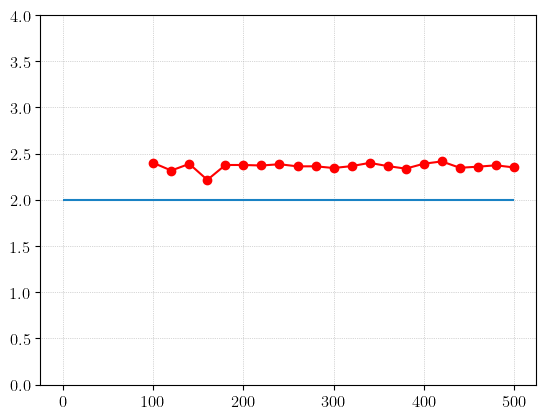

In [34]:
exps = []
decay = []
c = []
constraint_solver_steps = np.arange(100,520,20)#[100, 200, 300, 400, 500] 
for i in constraint_solver_steps:
    positions = read_json_file(f"/home/max/Temp/Praktikum/experiments/constraint_solver_steps_1/constraint_solver_steps_1_{i}/positions.json")
    current_exp = GuidewireExperiment(positions)
    tmp = get_decay_rate(current_exp, debug=True)
    decay.append(tmp[0])
    c.append(tmp[1])
    
plt.plot(constraint_solver_steps, decay, "o-", color="black", label="b")

plt.xlabel("Constraint Solver Steps")
plt.ylabel("Relaxation Time [m/s]")
plt.legend()
plt.yscale("log")
plt.show()
plt.plot(constraint_solver_steps, c, "o-", color="red", label="c")
plt.hlines(2,0,500)
plt.ylim(0,4)
plt.show()

Text(0, 0.5, 'Elapsed Time [s]')

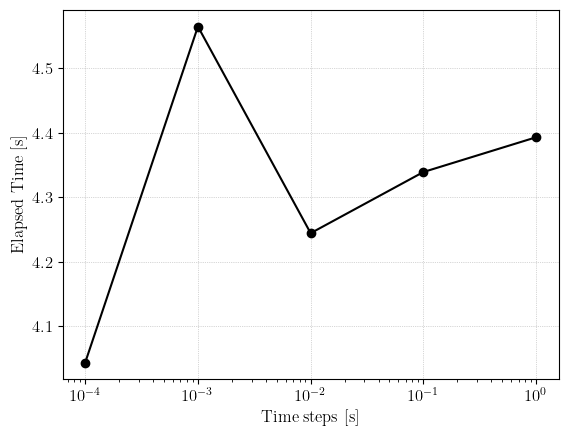

In [7]:
exps = []
decay = []
timesteps = [0.0001, 0.001, 0.01, 0.1, 1.0]

for i in timesteps:
    positions = read_json_file(f"/home/max/Temp/Praktikum/experiments/time_steps/time_steps_{i}/positions.json")
    current_exp = GuidewireExperiment(positions)
    decay.append(current_exp.get_elapsed_time()[-1]/1000)
    
plt.plot(timesteps, decay, "o-", color="black")
plt.xscale("log")
plt.xlabel("Time steps [s]")
plt.ylabel("Elapsed Time [s]")

Text(0, 0.5, 'Elapsed Time [s]')

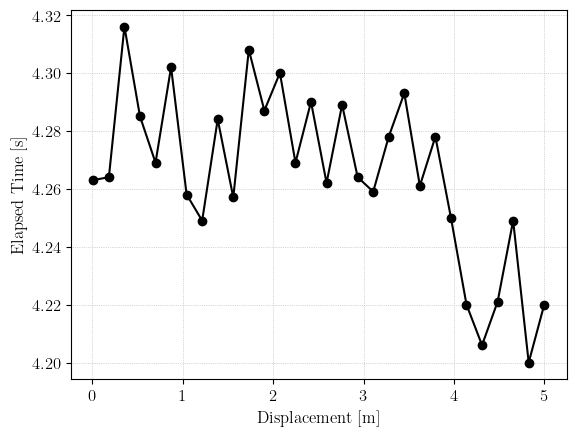

In [8]:
exps = []
decay = []
displacements = np.linspace(0.01,5, 30)

for i in displacements:
    positions = read_json_file(f"/home/max/Temp/Praktikum/experiments/displacement/displacement_{i}/positions.json")
    current_exp = GuidewireExperiment(positions)
    decay.append(current_exp.get_elapsed_time()[-1]/1000)
    
plt.plot(displacements, decay, "o-", color="black")
#plt.xscale("log")
plt.xlabel("Displacement [m]")
plt.ylabel("Elapsed Time [s]")

In [ ]:
''